# Customer Life Value Optimization Model
Goal: Develop a model using A/B testing to strategise discount targeting for maximised Customer Life Value (CLV)

#### Importing Packages

In [269]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

print("Packages imported successfully!")

Packages imported successfully!


#### Importing the data

In [147]:
# Removing index, and customer ID columns
# We use the encoded data, not normalized; we only want the features normal, not the output
data = pd.read_csv("data/data_encoded.csv").drop(columns=["Unnamed: 0", "Customer ID"])

data.head()

,Gender,Age,City,Membership Type,Total Spend,Items Purchased,Average Rating,Discount Applied,Days Since Last Purchase,Satisfaction Level
0,0,29,4,1,1120.20,14,4.6,1,25,1
1,1,34,2,2,780.50,11,4.1,0,18,0
2,0,43,0,0,510.75,9,3.4,1,42,2
3,1,30,5,1,1480.30,19,4.7,0,12,1
4,1,27,3,2,720.40,13,4.0,1,55,2


In [148]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Gender                    348 non-null    int64  
 1   Age                       348 non-null    int64  
 2   City                      348 non-null    int64  
 3   Membership Type           348 non-null    int64  
 4   Total Spend               348 non-null    float64
 5   Items Purchased           348 non-null    int64  
 6   Average Rating            348 non-null    float64
 7   Discount Applied          348 non-null    int64  
 8   Days Since Last Purchase  348 non-null    int64  
 9   Satisfaction Level        348 non-null    int64  
dtypes: float64(2), int64(8)
memory usage: 27.3 KB


## Feature Engineering

#### Creating Interaction Terms

Before continuing, there are vital insights from the ETL script that we must acknowledge prior to modelling:
- Customers' Genders are (mostly) segregated by City
- Whether or not a customer receieved a Discount is entirely based on City

Because of this, *City* must be treated as a *confounding variable*

In [149]:
data = pd.read_csv("data/data_raw.csv").drop(columns=[ "Customer ID"])
# Creating interaction terms between interaction features
cat_vars = ['City', 'Gender', 'Discount Applied', 'Membership Type', 'Satisfaction Level']

# Apply OneHotEncoder
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_cats = encoder.fit_transform(data[cat_vars])
encoded_cat_names = encoder.get_feature_names_out(cat_vars)
encoded_df = pd.DataFrame(encoded_cats, columns=encoded_cat_names) # Dropping a col that has 0 vals
data_enc = pd.concat([data, encoded_df], axis=1).drop(columns=cat_vars) # Dropping the non-encoded columns
encoded_df.head()


,City_Houston,City_Los Angeles,City_Miami,City_New York,City_San Francisco,Gender_Male,Discount Applied_True,Membership Type_Gold,Membership Type_Silver,Satisfaction Level_Satisfied,Satisfaction Level_Unsatisfied,Satisfaction Level_nan
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0


#### Feature Scaling

In [150]:
numerical_features = ["Age", "Items Purchased", "Days Since Last Purchase"]
data_scaled = data_enc.copy()
scaler = StandardScaler()

data_scaled[numerical_features] = scaler.fit_transform(data_scaled[numerical_features])
data_scaled[numerical_features].head()

,Age,Items Purchased,Days Since Last Purchase
0,-0.945152,0.337346,-0.118359
1,0.082826,-0.385538,-0.639907
2,1.933185,-0.867461,1.148256
3,-0.739557,1.542153,-1.086947
4,-1.356343,0.096385,2.116844


#### Interaction Terms

There are two major things to note here:

- **City**: It seems as though their Discount program was targeted by City, not by customer. We will have to keep this in mind when constructing models. Further, it does not seem as though, based on City alone, there was a strong effect of applying a discount; however, we cannot compare as we do not have independent data points.
- **Gender**: Discounts were much more heavily applied to Female customers as compared to Male.

We will create interaction terms to account for this

In [153]:
# Using the OneHotEncoded columns + Rating and Age to create interactions
interaction_features = encoded_cat_names.tolist() + ['Average Rating', 'Age']
poly = PolynomialFeatures(interaction_only=True, include_bias=False)
interaction_terms = poly.fit_transform(data_scaled[interaction_features])

# Convert interaction terms to DataFrame and add to the main data
interaction_term_names = poly.get_feature_names_out(interaction_features)
interaction_df = pd.DataFrame(interaction_terms, columns=interaction_term_names)

data_interaction = pd.concat([data_scaled, interaction_df], axis=1)
data_interaction.head()

,Age,Total Spend,Items Purchased,Average Rating,Days Since Last Purchase,City_Houston,City_Los Angeles,City_Miami,City_New York,City_San Francisco,...,Satisfaction Level_Satisfied Satisfaction Level_Unsatisfied,Satisfaction Level_Satisfied Satisfaction Level_nan,Satisfaction Level_Satisfied Average Rating,Satisfaction Level_Satisfied Age,Satisfaction Level_Unsatisfied Satisfaction Level_nan,Satisfaction Level_Unsatisfied Average Rating,Satisfaction Level_Unsatisfied Age,Satisfaction Level_nan Average Rating,Satisfaction Level_nan Age,Average Rating Age
0,-0.945152,1120.20,0.337346,4.6,-0.118359,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,4.6,-0.945152,0.0,0.0,-0.000000,0.0,-0.0,-4.347699
1,0.082826,780.50,-0.385538,4.1,-0.639907,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.339585
2,1.933185,510.75,-0.867461,3.4,1.148256,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,3.4,1.933185,0.0,0.0,6.572831
3,-0.739557,1480.30,1.542153,4.7,-1.086947,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,4.7,-0.739557,0.0,0.0,-0.000000,0.0,-0.0,-3.475916
4,-1.356343,720.40,0.096385,4.0,2.116844,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,-0.000000,0.0,4.0,-1.356343,0.0,-0.0,-5.425373


#### Base Model Selection

##### Train Test Split

In [197]:
def data_prep(data, lasso = True, view_features = False, alpha=0.01):
    """
    Function to split the data and, optionally, regularize and view regularization outputs.
    
    Parameters:
    - data: DataFrame containing the dataset.
    - lasso: Boolean flag to indicate whether Lasso regularization should be applied.
    - view_features: Boolean flag to print selected features and coefficients.
    - alpha: The alpha parameter for the Lasso regularization.
    
    Returns:
    X_train, X_test, y_train, y_test
    """
    # Initialize features (X) and target variable (y)
    X = data.drop(columns=['Total Spend'])  # Assuming 'Total Spend' is the target variable
    y = data['Total Spend']

    if lasso:
        # Initialize the Lasso model with the specified alpha
        lasso_model = Lasso(alpha=alpha, random_state=42)

        # Fit the Lasso model to the data
        lasso_model.fit(X, y)

        # Identify the features with non-zero coefficients
        selected_features = X.columns[lasso_model.coef_ != 0]
        
        if view_features:
            print("Selected Features:", selected_features.tolist())
            print("Lasso Coefficients:", lasso_model.coef_)

        # Select only the features with non-zero coefficients
        X = X[selected_features]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    return X_train, X_test, y_train, y_test

The following dictionary are the base models we will be testing

In [198]:
models = {
    LinearRegression(): "Linear Regression",
    RandomForestRegressor(random_state=42): "Random Forest Regression",
    GradientBoostingRegressor(random_state=42): "Gradient Boosting Regressor"
}

#### Model Selection

In [300]:
def model_selection(models=models, data=data, lasso=True, alpha = 0.01):
    """This function allows testing different models and data
        Utilises the previously made data_prep function"""
    X_train, X_test, y_train, y_test = data_prep(data=data, lasso=lasso, alpha = alpha)
    for model, name in models.items():
        # Train the model
        model.fit(X_train, y_train)
        
        # Predict on the test set
        y_pred = model.predict(X_test)
        
        # Calculate performance metrics
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        rmse = mse ** 0.5
        
        # Print model performance
        print(f"Model: {name}")
        print(f"Mean Squared Error: {mse:.2f}")
        print(f"Root Mean Squared Error: {rmse:.2f}")
        print(f"R-squared: {r2:.2f}\n")
        


##### Test 1: Encoded Data (Without Interaction Terms)

In [289]:
model_selection(data = data_enc, lasso = True)

Model: Linear Regression
Mean Squared Error: 239.01
Root Mean Squared Error: 15.46
R-squared: 1.00



(np.float64(239.00633615611372),
 np.float64(15.459829758316024),
 0.9982031848983803)

##### Test 2: Encoded, Scaled Data (Without Interaction Terms)

In [279]:
model_selection(data = data_scaled, lasso = True)

Model: Linear Regression
Mean Squared Error: 239.01
Root Mean Squared Error: 15.46
R-squared: 1.00

Model: Random Forest Regression
Mean Squared Error: 402.33
Root Mean Squared Error: 20.06
R-squared: 1.00

Model: Gradient Boosting Regressor
Mean Squared Error: 263.62
Root Mean Squared Error: 16.24
R-squared: 1.00



##### Test 3: Encoded, Scaled Data (With Interaction Terms)

In [302]:
model_selection(data = data_interaction, lasso = True, alpha = 0.9)

Model: Linear Regression
Mean Squared Error: 291.57
Root Mean Squared Error: 17.08
R-squared: 1.00

Model: Random Forest Regression
Mean Squared Error: 196.29
Root Mean Squared Error: 14.01
R-squared: 1.00

Model: Gradient Boosting Regressor
Mean Squared Error: 93.60
Root Mean Squared Error: 9.67
R-squared: 1.00



Judging by the RMSE and R-squared values, we will continue with the GBR (Gradience Boosting Regressor), using the scaled, encoded data with interaction terms.

#### Hyperparameter Tuning

##### Testing different alphas

In [303]:
alphas = np.arange(0.05,1,0.01)
alpha_scores = {}
for alpha in alphas:
    X_train, X_test, y_train, y_test = data_prep(data=data_interaction, lasso=True, alpha = alpha)
    model = GradientBoostingRegressor(random_state=42)
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Calculate performance metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    rmse = mse ** 0.5
    
    # Print model performance
    print(f"Alpha: {alpha}")
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"Root Mean Squared Error: {rmse:.2f}")
    print(f"R-squared: {r2:.2f}\n")

    alpha_scores[alpha]=rmse

Alpha: 0.05
Mean Squared Error: 268.85
Root Mean Squared Error: 16.40
R-squared: 1.00

Alpha: 0.060000000000000005
Mean Squared Error: 181.31
Root Mean Squared Error: 13.47
R-squared: 1.00

Alpha: 0.07
Mean Squared Error: 237.57
Root Mean Squared Error: 15.41
R-squared: 1.00

Alpha: 0.08000000000000002
Mean Squared Error: 242.28
Root Mean Squared Error: 15.57
R-squared: 1.00

Alpha: 0.09000000000000001
Mean Squared Error: 253.24
Root Mean Squared Error: 15.91
R-squared: 1.00

Alpha: 0.1
Mean Squared Error: 249.82
Root Mean Squared Error: 15.81
R-squared: 1.00

Alpha: 0.11000000000000001
Mean Squared Error: 252.26
Root Mean Squared Error: 15.88
R-squared: 1.00

Alpha: 0.12000000000000002
Mean Squared Error: 251.51
Root Mean Squared Error: 15.86
R-squared: 1.00

Alpha: 0.13
Mean Squared Error: 251.51
Root Mean Squared Error: 15.86
R-squared: 1.00

Alpha: 0.14
Mean Squared Error: 251.51
Root Mean Squared Error: 15.86
R-squared: 1.00

Alpha: 0.15000000000000002
Mean Squared Error: 251.51
R

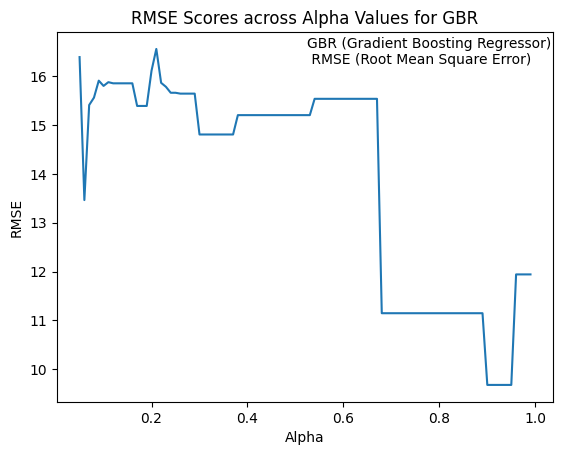

In [334]:
sns.lineplot(alpha_scores)
plt.xlabel("Alpha")
plt.ylabel("RMSE")
plt.title("RMSE Scores across Alpha Values for GBR")
plt.text(x=.525, y =16.25, s="GBR (Gradient Boosting Regressor)\n RMSE (Root Mean Square Error)")
plt.show()

In [337]:
lowest_alpha = min(alpha_scores, key = alpha_scores.get)
lowest_rmse = min(alpha_scores.values())
print(f"The lowest RMSE of {lowest_rmse:.2f} was found when using alpha of {lowest_alpha:.2f}")

The lowest RMSE of 9.67 was found when using alpha of 0.90


In [355]:
clv_model = RandomForestRegressor(random_state=42,)
X_train, X_test, y_train, y_test = data_prep(data_interaction, lasso=True, alpha = 0.85)

param_grid_rf = {
    'n_estimators': [300, 350, 400],
    'max_depth': [None, 5,10, 15],
    'min_samples_split': [1, 2, 4],
    'min_samples_leaf': [1, 2, 4],
    'random_state': [42]
    }
grid_search_rf = GridSearchCV(estimator=clv_model,
                              param_grid=param_grid_rf,
                              cv=5,
                              scoring='neg_mean_squared_error',
                              verbose=1)
grid_search_rf.fit(X_train, y_train)

nmse = grid_search_rf.best_score_
mse = -nmse
rmse = mse **(1/2)

print(f"Best Parameters for Random Forest: {grid_search_rf.best_params_}")
print(f"Best MSE: {mse}")
print(f"Best RMSE: {rmse}")

clv_model = grid_search_rf.best_estimator_

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters for Random Forest: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 350, 'random_state': 42}
Best MSE: 91.51708785688422
Best RMSE: 9.566456389744545


In [ ]:
data['Predicted_CLV_Baseline'] = clv_model.predict(X)
data[["Total Spend","Predicted_CLV_Baseline"]]

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- City_Houston City_Los Angeles
- City_Houston City_Miami
- City_Houston City_New York
- City_Houston City_San Francisco
- City_Houston Discount Applied_True
- ...


In [ ]:
# Step 3: Split Data into Treatment and Control Groups
treatment = data[data['Discount Applied'] == 1]
control = data[data['Discount Applied'] == 0]

In [ ]:
categorical_variables = ['Gender', 'City', 'Membership Type']

for var in categorical_variables:
    # Control Group
    control_dist = control[var].value_counts(normalize=True)
    
    # Treatment Group
    treatment_dist = treatment[var].value_counts(normalize=True)
    
    # Create a 1x2 grid of pie charts
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Control Group Pie Chart
    axes[0].pie(control_dist, labels=control_dist.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
    axes[0].set_title(f'{var} Distribution in No Discount Group')
    
    # Treatment Group Pie Chart
    axes[1].pie(treatment_dist, labels=treatment_dist.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
    axes[1].set_title(f'{var} Distribution in Discount Group')
    
    # Display the plots
    plt.suptitle(f'Comparison of {var} Distribution between Control and Treatment Groups')
    plt.show()


In [ ]:
# Compare the mean CLV of the test and control groups for each feature
features_to_test = ['Gender', 'City', 'Membership Type', 
                    'Discount_Satisfaction_Interaction']

In [ ]:
control_mean = control.groupby('City')['Total Spend'].mean()
print(control_mean)
test_mean = treatment.groupby('City')['Total Spend'].mean()
print(test_mean)
uplift = test_mean - control_mean
print(f"Uplift in CLV for 'City': \n{uplift}\n")

In [ ]:
print("Statistical Analysis of Features' Response to Discount:")
for feature in features_to_test:
    control_mean = control.groupby(feature)['Total Spend'].mean()
    test_mean = treatment.groupby(feature)['Total Spend'].mean()
    uplift = test_mean - control_mean
    print(f"Uplift in CLV for {feature}: \n{uplift}\n")

In [ ]:
# Define the features and target for treatment group
X_treatment = treatment.drop(columns = "Total Spend")
y_treatment = treatment['Total Spend']

In [ ]:
# Define the features and target
X_control = control.drop(columns = "Total Spend")
y_control = control['Total Spend']

In [ ]:
# Initialize models
treatment_model = GradientBoostingRegressor(random_state=42)
control_model = GradientBoostingRegressor(random_state=42)

# Train models
treatment_model.fit(X_treatment, y_treatment)
control_model.fit(X_control, y_control)

In [ ]:
# Predict CLV for both groups
treatment_predictions = treatment_model.predict(X_treatment)
control_predictions = control_model.predict(X_control)

# Calculate the expected uplift for each customer
data['Predicted_CLV_Treatment'] = treatment_model.predict(data[X_treatment.columns])
data['Predicted_CLV_Control'] = control_model.predict(data[X_control.columns])
data['Uplift'] = data['Predicted_CLV_Treatment'] - data['Predicted_CLV_Control']

data[['Predicted_CLV_Treatment','Predicted_CLV_Control','Uplift']].head()

In [ ]:
data[['Predicted_CLV_Treatment','Predicted_CLV_Control','Uplift']].describe()

In [ ]:
uplift_threshold = data['Uplift'].quantile(0.50)  # Adjust this threshold as needed
data['Target_for_Discount'] = data['Uplift'] > uplift_threshold
data.head()

In [ ]:
# Uplift distribution
sns.histplot(data['Uplift'], kde=True)
plt.title('Uplift Distribution')
plt.xlabel('Uplift (Predicted CLV Treatment - Predicted CLV Control)')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Percentage of customers targeted for discount
target_ratio = data['Target_for_Discount'].mean() * 100
print(f"\nPercentage of customers identified to receive a discount: {target_ratio:.2f}%")

In [ ]:
# Calculate the average uplift for customers who are targeted
average_uplift = data[data['Target_for_Discount'] == True]['Uplift'].mean()
print(f"\nAverage uplift in CLV for targeted customers: ${average_uplift:.2f}")

# Potential increase in revenue if targeted customers receive discounts
potential_increase = average_uplift * data['Target_for_Discount'].sum()
print(f"Potential increase in revenue from targeted discounts: ${potential_increase:.2f}")

In [ ]:
if hasattr(treatment_model, 'feature_importances_'):
    feature_importance = pd.Series(treatment_model.feature_importances_, index=X_control.columns).sort_values(ascending=False)
    sns.barplot(x=feature_importance.values, y=feature_importance.index)
    plt.title('Feature Importance for Treatment Group')
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.show()

print(feature_importance)

In [ ]:
# Create groups
control_group = data[data['Discount Applied'] == 0]['Total Spend']
test_group = data[data['Discount Applied'] == 1]['Total Spend']

In [ ]:
t_stat, p_value = stats.ttest_ind(control_group, test_group, equal_var=False)
print(f'\nA/B Testing Results:')
print(f'Test Group Mean CLV: {test_group.mean():.2f}')
print(f'Control Group Mean CLV: {control_group.mean():.2f}')
print(f'T-statistic: {t_stat:.2f}, P-value: {p_value:.4f}')